In [2]:
import torch 

---
Data & Configuration setup

---
DataSet Classes & DataLoaders

In [1]:
import torch

def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max_val()  # trick works because of overloading of 'or' operator for non-boolean types
    return (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))

In [4]:
sample_mask = padding_mask(torch.tensor([12, 15, 14, 14, 15], dtype=torch.int16), 15)
sample_mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]])

In [16]:
# build mock dataloader
import numpy as np 
import torch
from torch.utils.data import Dataset, DataLoader

class MockDataset(Dataset):
    def __init__(self, n, max_len, n_ft, n_attr, n_actions, target_feat=None):
        super(MockDataset, self).__init__()
        self.n = n 
        self.max_len = max_len 
        self.n_ft = n_ft 
        self.n_attr = n_attr 
        self.n_action = n_actions
        self.target_feat = target_feat
        # set up dataset 
        self.build_dataset()


    def build_dataset(self):
        self.data = torch.rand((self.n, self.max_len, self.n_ft))
        self.actions = list(range(self.n_action))
        self.targets = np.random.choice(self.actions, size=self.n, replace=True)
        self.targets = torch.from_numpy(self.targets)
        if self.target_feat == None:
            self.target_feat = torch.rand((self.n_action, self.n_ft))
        attr_met = np.random.choice([0, 1], size=self.n_attr*self.n_action).reshape((self.n_action, self.n_attr))
        self.attr_met = torch.from_numpy(attr_met)
        self.padding_mask = torch.ones((self.n, self.max_len, self.n_ft)).to(bool)

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = self.padding_mask[ind, ...]
        y = self.targets[ind]
        y_feat = self.target_feat[y, ...]
        attr = self.attr_met[y, ...]
        return x, y, y_feat, attr, x_mask

    def __len__(self):
        return self.data.shape[0]


In [13]:
sample_dt = MockDataset(100, 120, 16, 20, 12)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True)

In [14]:
for x,y,y_feat,attr,mask in sample_dt:
    break

In [15]:
mask

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [6]:
x.shape

torch.Size([120, 16])

In [7]:
y

tensor(4, dtype=torch.int32)

In [8]:
attr

tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       dtype=torch.int32)

---
Setup Model

In [17]:
import numpy as np 
import math

import torch 
from torch import nn, Tensor
from torch.nn import functional as F 

In [18]:
# relative global attention based transformer encoder implementation
class RelativeGlobalAttention(nn.Module):
    def __init__(self, d_model, num_heads, max_len=1024, dropout=0.1):
        super().__init__()
        d_head, remainder = divmod(d_model, num_heads)
        if remainder:
            raise ValueError(
                "incompatible `d_model` and `num_heads`"
            )
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.Er = nn.Parameter(torch.randn(max_len, d_head))
        self.register_buffer(
            "mask", 
            torch.tril(torch.ones(max_len, max_len))
            .unsqueeze(0).unsqueeze(0)
        )

    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        if seq_len > self.max_len:
            raise ValueError(
                "sequence length exceeds model capacity"
            )
        
        k_t = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        
        start = self.max_len - seq_len
        Er_t = self.Er[start:, :].transpose(0, 1) # automatic positional padding
        QEr = torch.matmul(q, Er_t)
        Srel = self.skew(QEr)
        
        QK_t = torch.matmul(q, k_t)
        attn = (QK_t + Srel) / math.sqrt(q.size(-1))
        mask = self.mask[:, :, :seq_len, :seq_len]
        attn = attn.masked_fill(mask == 0, float("-inf"))
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        return self.dropout(out)
        
    
    def skew(self, QEr):
        padded = F.pad(QEr, (1, 0))
        batch_size, num_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
        Srel = reshaped[:, :, 1:, :]
        return Srel

In [19]:
# build E2E ZSL HAR Model

class ZSLHARNet(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, attr_size, max_len=1024, dropout=0.1):
        super().__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size # semantic space size <-> output feature space size
        self.attr_size = attr_size # intermediate attribute space size 

        # custom sample layer configuration
        # Dense layer for feature projection
        self.DenseL = nn.Linear(in_ft, d_model)
        # attention encoder <-> global relative attention used here
        self.AttnL = RelativeGlobalAttention(d_model, num_heads, max_len)
        # positional encoding concat <-> LSTM 
        self.lstmL = nn.LSTM(input_size=d_model, hidden_size=ft_size, batch_first=True)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))


    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        lstm_out, hidden = self.lstmL(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(lstm_out[:, -1, :])
        ft_out = self.DecDenseL(attr_out)
        return attr_out, ft_out

In [20]:
model = ZSLHARNet(in_ft=6, d_model=128, num_heads=8, ft_size=64, attr_size=16, max_len=120)

In [21]:
sample_input = torch.randn((32, 120, 6))

attr_out, feat_out = model(sample_input)
print(attr_out.shape, feat_out.shape)

torch.Size([32, 16]) torch.Size([32, 64])


---
Setup Training & evaluation pipeline

In [68]:
from sklearn import metrics
import matplotlib.pyplot as plt

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep

    
    plt.figure()
    plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                            title='Confusion matrix normalized by row')
    plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind)
    # Print report
    print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"total_accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

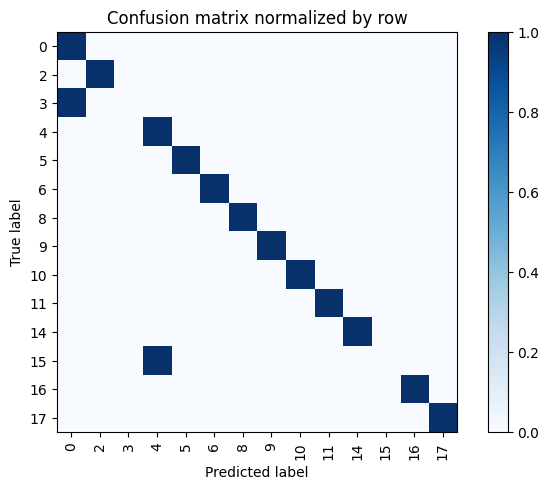

Overall accuracy: 0.938

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

         16       1.000      1.000      1.000      0.156          5|	 17: 0.000,	15: 0.000,	
         17       1.000      1.000      1.000      0.125          4|	 16: 0.000,	15: 0.000,	
          6       1.000      1.000      1.000      0.125          4|	 17: 0.000,	16: 0.000,	
         10       1.000      1.000      1.000      0.094          3|	 17: 0.000,	16: 0.000,	
          8       1.000      1.000      1.000      0.094          3|	 17: 0.000,	16: 0.000,	
          4       0.750      1.000      0.857      0.094          3|	 17: 0.000,	16: 0.000,	
         14       1.000      1.000      1.000      0.062          2|	 17: 0.000,	16: 0.000,	
          0       0.667      1.000      0.800      0.062          2|	 17: 0.000,	16: 0.000,	
         15       0.000      0.000      0.000      0.031          1|	 4: 1.000,	17: 0.000,	16: 0.000,	
         11       1.000      1.000      1

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'total_accuracy': 0.9375,
 'precision': 0.8154761904761905,
 'recall': 0.8571428571428571,
 'f1': 0.8326530612244898}

In [23]:
action_classes = list(range(18))
class_names = [str(i) for i in action_classes]
y_true = np.random.choice(action_classes, size=32, replace=True)
# y_pred = np.random.choice(action_classes, size=32, replace=True)
y_pred = y_true.copy()
y_pred[2] = 4
y_pred[14] = 0
action_evaluator(y_pred, y_true, class_names)

In [71]:
import torch 
from torch import nn, Tensor
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from tqdm import tqdm 

In [24]:
# build loss module
class FeatureLoss(nn.Module):
    def __init__(self):
        super(FeatureLoss, self).__init__()
        # self.add_aux = add_aux 
        self.loss_func = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, y_pred, y_true):
        batch_loss = self.loss_func(y_pred, y_true)
        final_loss = torch.abs(batch_loss.mean())
        return final_loss

In [19]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
loss = FeatureLoss()
output = loss(input1, input2)
output

tensor(0.0029)

In [25]:
class AttributeLoss(nn.Module):
    def __init__(self):
        super(AttributeLoss, self).__init__()
        self.loss_func = nn.BCELoss()
        self.m = nn.Sigmoid()

    def forward(self, attr_pred, attr_true):
        output = self.loss_func(self.m(attr_pred), attr_true)
        return output

In [37]:
pred = torch.randn(32, 20)
true = torch.empty(32, 20).random_(2)
# loss = nn.BCELoss()
# m = nn.Sigmoid()
loss = AttributeLoss()
output = loss(pred, true)
output

tensor(0.8271)

In [38]:
output.item()

0.8270800709724426

In [10]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)
output.mean()

tensor(-0.0059)

In [7]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output

tensor(1.6425, grad_fn=<NllLossBackward0>)

In [69]:
def train_step(model, dataloader, optimizer, loss_module, loss_alpha, device, class_names, target_feat_met, phase='train', l2_reg=False):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                attr_output, feat_output = model(X)
                # print("feature shape", feat_output.shape, "target feature shape", target_feat.shape)
                feat_loss = loss_module['feature'](feat_output, target_feat)
                attr_loss = loss_module['attribute'](attr_output, target_attr)

            # define composite loss function
            loss = loss_alpha*feat_loss+(1-loss_alpha)*attr_loss
            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            # if i % print_interval == 0:
            #     ending = "" if epoch_num is None else 'Epoch {} '.format(epoch_num)
            #     self.print_callback(i, metrics, prefix='Training ' + ending)

            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            feat_numpy = feat_output.cpu().detach()
            action_probs = cosine_similarity(feat_numpy, target_feat_met)
            pred_action = np.argmax(action_probs, axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_action)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [25]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [26]:
action_feature = np.random.rand(18, 64)
batch_pred = np.random.rand(32, 64)

In [27]:
cos_met = cosine_similarity(batch_pred, action_feature)
cos_met.shape

(32, 18)

In [31]:
np.argmax(cos_met, axis=1)

array([ 0, 17,  9, 13, 17,  4,  1, 17, 17,  9,  4,  7,  0, 17, 17, 17, 14,
       17,  0,  1, 15,  5, 10,  0,  9, 17,  9, 17,  4,  9, 17, 17],
      dtype=int64)

In [72]:
def eval_step(model, dataloader, loss_module, loss_alpha, device, class_names, target_feat_met, phase='train', l2_reg=False):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                attr_output, feat_output = model(X)
                # print("feature shape", feat_output.shape, "target feature shape", target_feat.shape)
                feat_loss = loss_module['feature'](feat_output, target_feat)
                attr_loss = loss_module['attribute'](attr_output, target_attr)

            # define composite loss function
            loss = loss_alpha*feat_loss+(1-loss_alpha)*attr_loss

            # convert feature vector into action class
            # using cosine 
            feat_numpy = feat_output.cpu().detach()
            action_probs = cosine_similarity(feat_numpy, target_feat_met)
            pred_action = np.argmax(action_probs, axis=1)
            
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names)
    return metrics_dict


---
Attribute evaluate

---
Main

In [30]:
from torch.optim import Adam
from tqdm import tqdm

train: 100%|██████████| 16/16 [00:00<00:00, 43.92batch/s]
C:\Users\deela\AppData\Local\Temp\ipykernel_25404\917593703.py:108: RuntimeWarning: invalid value encountered in divide
  ConfMatrix_normalized_row = ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep


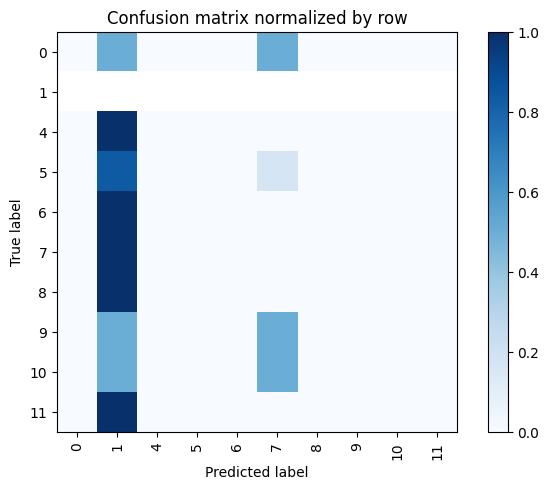

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.000

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          5       0.000      0.000      0.000      0.300        6.0|	 1: 0.833,	7: 0.167,	11: 0.000,	
          6       0.000      0.000      0.000      0.150        3.0|	 1: 1.000,	11: 0.000,	10: 0.000,	
         10       0.000      0.000      0.000      0.100        2.0|	 7: 0.500,	1: 0.500,	11: 0.000,	
          9       0.000      0.000      0.000      0.100        2.0|	 7: 0.500,	1: 0.500,	11: 0.000,	
          4       0.000      0.000      0.000      0.100        2.0|	 1: 1.000,	11: 0.000,	10: 0.000,	
          0       0.000      0.000      0.000      0.100        2.0|	 7: 0.500,	1: 0.500,	11: 0.000,	
         11       0.000      0.000      0.000      0.050        1.0|	 1: 1.000,	10: 0.000,	
          8       0.000      0.000      0.000      0.050        1.0|	 1: 1.000,	11: 0.000,	10: 0.000,	
          7       0.000      0.000      0.000      0.050        1.0|	 1: 1.000,

eval: 100%|██████████| 4/4 [00:00<00:00, 67.99batch/s, loss=0.314]


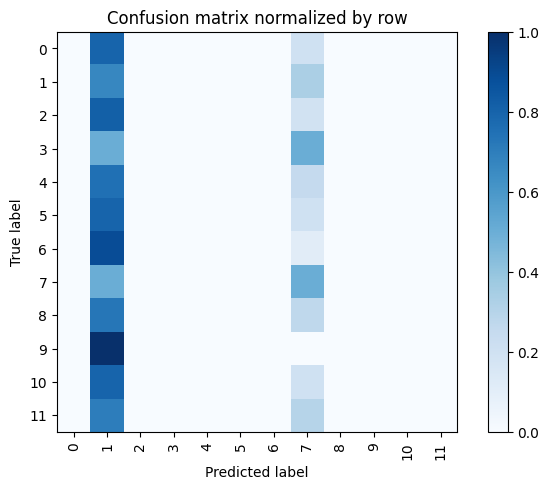

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

Overall accuracy: 0.070

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          2       0.000      0.000      0.000      0.160         16|	 1: 0.812,	7: 0.188,	11: 0.000,	
          0       0.000      0.000      0.000      0.150         15|	 1: 0.800,	7: 0.200,	11: 0.000,	
          8       0.000      0.000      0.000      0.110         11|	 1: 0.727,	7: 0.273,	11: 0.000,	
         11       0.000      0.000      0.000      0.100         10|	 1: 0.700,	7: 0.300,	
          3       0.000      0.000      0.000      0.100         10|	 7: 0.500,	1: 0.500,	11: 0.000,	
          6       0.000      0.000      0.000      0.090          9|	 1: 0.889,	7: 0.111,	11: 0.000,	
          7       0.115      0.500      0.188      0.060          6|	 1: 0.500,	11: 0.000,	
          1       0.054      0.667      0.100      0.060          6|	 7: 0.333,	11: 0.000,	
         10       0.000      0.000      0.000      0.050          5|	 1: 0.800,	7: 0.200,	11: 0.000,	
 

train: 100%|██████████| 16/16 [00:00<00:00, 43.09batch/s]


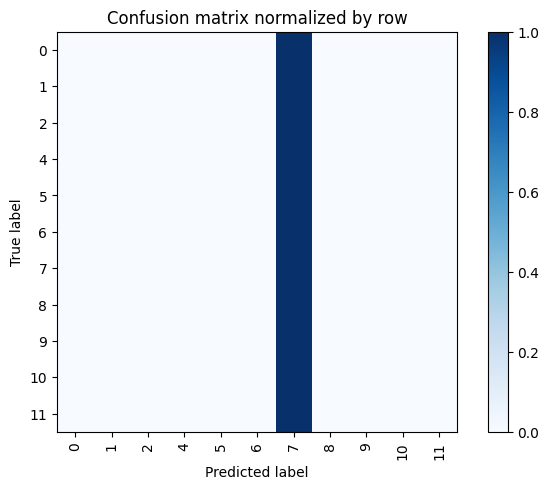

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.100

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

         10       0.000      0.000      0.000      0.150          3|	 7: 1.000,	11: 0.000,	
          9       0.000      0.000      0.000      0.150          3|	 7: 1.000,	11: 0.000,	10: 0.000,	
          6       0.000      0.000      0.000      0.150          3|	 7: 1.000,	11: 0.000,	10: 0.000,	
          7       0.100      1.000      0.182      0.100          2|	 11: 0.000,	10: 0.000,	
          4       0.000      0.000      0.000      0.100          2|	 7: 1.000,	11: 0.000,	10: 0.000,	
          1       0.000      0.000      0.000      0.100          2|	 7: 1.000,	11: 0.000,	10: 0.000,	
         11       0.000      0.000      0.000      0.050          1|	 7: 1.000,	10: 0.000,	
          8       0.000      0.000      0.000      0.050          1|	 7: 1.000,	11: 0.000,	10: 0.000,	
          5       0.000      0.000      0.000      0.050          1|	 7: 1.000,	11: 0.000,	10: 0

eval: 100%|██████████| 4/4 [00:00<00:00, 57.97batch/s, loss=0.231]


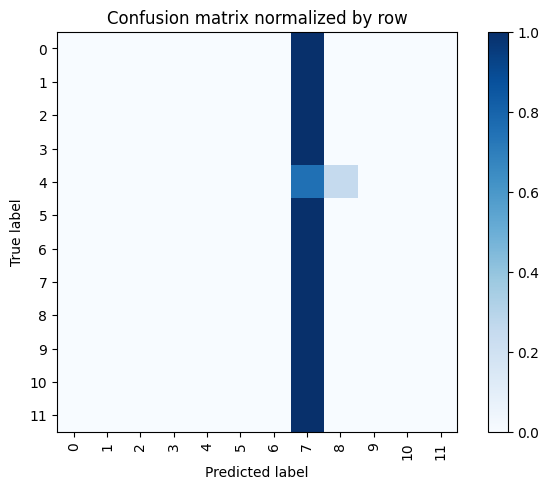

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

Overall accuracy: 0.060

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          2       0.000      0.000      0.000      0.160         16|	 7: 1.000,	11: 0.000,	10: 0.000,	
          0       0.000      0.000      0.000      0.150         15|	 7: 1.000,	11: 0.000,	10: 0.000,	
          8       0.000      0.000      0.000      0.110         11|	 7: 1.000,	11: 0.000,	10: 0.000,	
         11       0.000      0.000      0.000      0.100         10|	 7: 1.000,	10: 0.000,	
          3       0.000      0.000      0.000      0.100         10|	 7: 1.000,	11: 0.000,	10: 0.000,	
          6       0.000      0.000      0.000      0.090          9|	 7: 1.000,	11: 0.000,	10: 0.000,	
          7       0.061      1.000      0.114      0.060          6|	 11: 0.000,	10: 0.000,	
          1       0.000      0.000      0.000      0.060          6|	 7: 1.000,	11: 0.000,	10: 0.000,	
         10       0.000      0.000      0.000      0.050          5|	 7: 1.000,	11: 0

train: 100%|██████████| 16/16 [00:00<00:00, 43.42batch/s]


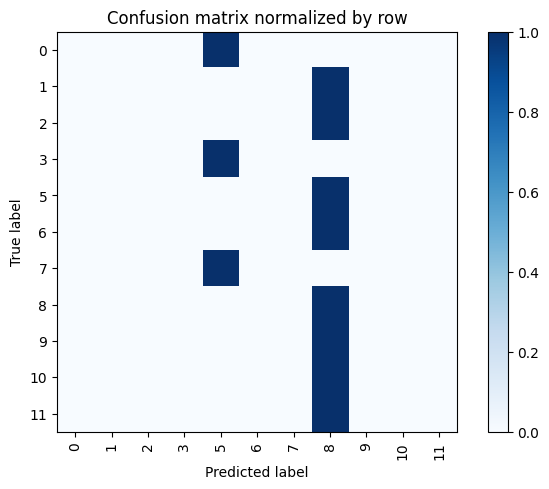

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.100

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          6       0.000      0.000      0.000      0.150          3|	 8: 1.000,	11: 0.000,	10: 0.000,	
          2       0.000      0.000      0.000      0.150          3|	 8: 1.000,	11: 0.000,	10: 0.000,	
         11       0.000      0.000      0.000      0.100          2|	 8: 1.000,	10: 0.000,	
         10       0.000      0.000      0.000      0.100          2|	 8: 1.000,	11: 0.000,	
          8       0.125      1.000      0.222      0.100          2|	 11: 0.000,	10: 0.000,	
          5       0.000      0.000      0.000      0.100          2|	 8: 1.000,	11: 0.000,	10: 0.000,	
          0       0.000      0.000      0.000      0.100          2|	 5: 1.000,	11: 0.000,	10: 0.000,	
          9       0.000      0.000      0.000      0.050          1|	 8: 1.000,	11: 0.000,	10: 0.000,	
          7       0.000      0.000      0.000      0.050          1|	 5: 1.000,	11: 0.000,	10: 0

eval: 100%|██████████| 4/4 [00:00<00:00, 78.43batch/s, loss=0.23]


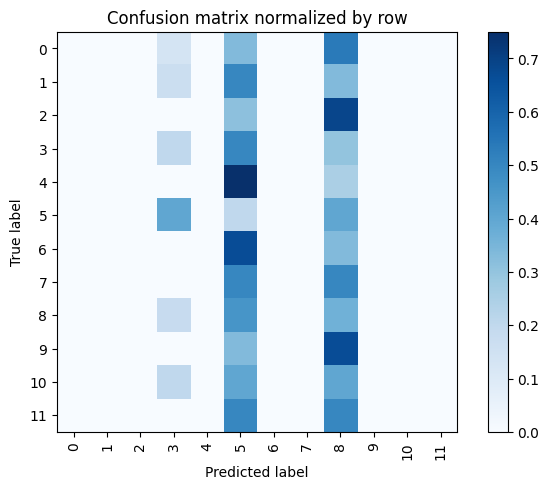

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                             

Overall accuracy: 0.070

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          2       0.000      0.000      0.000      0.160         16|	 8: 0.688,	5: 0.312,	11: 0.000,	
          0       0.000      0.000      0.000      0.150         15|	 8: 0.533,	5: 0.333,	3: 0.133,	
          8       0.087      0.364      0.140      0.110         11|	 5: 0.455,	3: 0.182,	
         11       0.000      0.000      0.000      0.100         10|	 8: 0.500,	5: 0.500,	
          3       0.200      0.200      0.200      0.100         10|	 5: 0.500,	8: 0.300,	
          6       0.000      0.000      0.000      0.090          9|	 5: 0.667,	8: 0.333,	11: 0.000,	
          7       0.000      0.000      0.000      0.060          6|	 8: 0.500,	5: 0.500,	11: 0.000,	
          1       0.000      0.000      0.000      0.060          6|	 5: 0.500,	8: 0.333,	3: 0.167,	
         10       0.000      0.000      0.000      0.050          5|	 8: 0.400,	5: 0.400,	3: 0.200,	
      

In [73]:
# run

# data reader
# dataReader = PAMAP2Reader('../data/PAMAP2_Dataset/Protocol/')
class_names = [str(i) for i in range(12)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# setup dataset
train_dt = MockDataset(n=500, max_len=120, n_ft=16, n_attr=32, n_actions=12)
eval_dt = MockDataset(n=100, max_len=120, n_ft=16, n_attr=32, n_actions=12, target_feat=train_dt.target_feat)
train_dl = DataLoader(train_dt, batch_size=32, shuffle=True, pin_memory=True)
eval_dl = DataLoader(eval_dt, batch_size=32, shuffle=True, pin_memory=True)

unseen_dt = MockDataset(n=200, max_len=120, n_ft=16, n_attr=32, n_actions=4)
unseen_dl = DataLoader(unseen_dt, batch_size=32, shuffle=True, pin_memory=True)

# config model
lr = 0.001
epochs = 3

model = ZSLHARNet(in_ft=16, d_model=128, num_heads=8, ft_size=16, attr_size=32, max_len=120)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
loss_module = {'feature': FeatureLoss(), 'attribute': AttributeLoss()}



for epoch in tqdm(range(epochs), desc='Training Epoch', leave=False):
    train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=class_names, target_feat_met=train_dt.target_feat, phase='train')
    eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=class_names,  target_feat_met=train_dt.target_feat, phase='eval')
    # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
    # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")

In [ ]:
# Initialize data generators
dataset_class, collate_fn, runner_class = pipeline_factory(config)
val_dataset = dataset_class(val_data, val_indices)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config['batch_size'],
                        shuffle=False,
                        num_workers=config['num_workers'],
                        pin_memory=True,
                        collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

train_dataset = dataset_class(my_data, train_indices)

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=config['batch_size'],
                            shuffle=True,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

trainer = runner_class(model, train_loader, device, loss_module, optimizer, l2_reg=output_reg,
                                print_interval=config['print_interval'], console=config['console'])
val_evaluator = runner_class(model, val_loader, device, loss_module,
                                    print_interval=config['print_interval'], console=config['console'])

tensorboard_writer = SummaryWriter(config['tensorboard_dir'])

best_value = 1e16 if config['key_metric'] in NEG_METRICS else -1e16  # initialize with +inf or -inf depending on key metric
metrics = []  # (for validation) list of lists: for each epoch, stores metrics like loss, ...
best_metrics = {}